In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler
#import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')
import os              
os.environ['PYTHONHASHSEED'] = '0'
sc.settings.set_figure_params(dpi=100, facecolor='white')
import scipy

#### Load Dataset Lung

In [2]:
adata = sc.read("/home/lugli/spuccio/Projects/SP025_NaClTcell/Analysis/adata.h5ad")

In [3]:
adata.shape

(174834, 33487)

In [4]:
print(adata.n_obs, adata.n_vars)
mito_genes = adata.var_names.str.startswith('MT')
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
remove = np.add(ribo_genes, mito_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

174834 33487
174834 33487


In [8]:
adata.obs

,CellId,CellFromTumor,PatientNumber,TumorType,TumorSite,CellType,batch
barcode,,,,,,,
BT1290_AAACCTGAGTAACCCT,NaN,Tumor,Ptz1,Lung,O,B_cell,0
BT1290_AAACCTGCAACGATGG,NaN,Tumor,Ptz1,Lung,O,Myeloid,0
BT1290_AAACCTGCATTAGCCA,NaN,Tumor,Ptz1,Lung,O,Myeloid,0
BT1290_AAACCTGGTCCATGAT,NaN,Tumor,Ptz1,Lung,O,T_cell,0
BT1290_AAACCTGGTCCGAGTC,NaN,Tumor,Ptz1,Lung,O,Cancer,0
...,...,...,...,...,...,...,...
scrSOL007_TTTGTCAGTACCGAGA,scrSOL007_TTTGTCAGTACCGAGA,Peritumor,Ptz22,Ovarian,Ovarium,Fibroblast,3
scrSOL007_TTTGTCAGTGAAAGAG,scrSOL007_TTTGTCAGTGAAAGAG,Peritumor,Ptz22,Ovarian,Ovarium,Fibroblast,3
scrSOL007_TTTGTCAGTGAAGGCT,scrSOL007_TTTGTCAGTGAAGGCT,Peritumor,Ptz22,Ovarian,Ovarium,Myeloid,3


#### Filter CD45+ 

In [9]:
adataCD45 = adata[adata.obs['CellType']  != "Cancer",:]

#### Filter CD45-

In [10]:
adataCancer = adata[adata.obs['CellType']  == "Cancer",:]

#### Save

In [15]:
del adata

In [12]:
adataCD45.write("/home/lugli/spuccio/Projects/SP025_NaClTcell//Analysis/Integrated/adataCD45.h5ad")
adataCancer.write("/home/lugli/spuccio/Projects/SP025_NaClTcell/Analysis//Integrated/adataCancer.h5ad")

#### Run Harmony

In [ ]:
adataCD45 = sc.read("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated/adataCD45.h5ad")

In [13]:
import scanpy.external as sce

In [14]:
sc.tl.pca(adataCD45,svd_solver='arpack',copy=False)

In [16]:
sce.pp.harmony_integrate(adataCD45, 'batch')

2023-02-08 12:04:38,955 - harmonypy - INFO - Iteration 1 of 10
2023-02-08 12:05:16,326 - harmonypy - INFO - Iteration 2 of 10
2023-02-08 12:05:53,773 - harmonypy - INFO - Iteration 3 of 10
2023-02-08 12:06:31,314 - harmonypy - INFO - Converged after 3 iterations


In [17]:
sc.pp.neighbors(adataCD45, n_neighbors=10, use_rep='X_pca_harmony')

2023-02-08 12:13:13.749838: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 12:13:13.909406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 12:13:13.909446: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### UMAP

In [18]:
sc.tl.umap(adataCD45,min_dist=0.01)

#### Cell Annotation

In [19]:
import celltypist
from celltypist import models

In [20]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [23]:
adataCD45.X = adataCD45.layers['counts']

In [24]:
sc.pp.normalize_total(adataCD45, target_sum=1e4,exclude_highly_expressed=True)
sc.pp.log1p(adataCD45)

In [25]:
predictions = celltypist.annotate(adataCD45, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 126983 cells and 33487 genes
🔗 Matching reference genes in the model
🧬 5529 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [26]:
adataCD45 = predictions.to_adata()

In [27]:
adataCD45.obs

,CellId,CellFromTumor,PatientNumber,TumorType,TumorSite,CellType,batch,predicted_labels,over_clustering,majority_voting,conf_score
barcode,,,,,,,,,,,
BT1290_AAACCTGAGTAACCCT,NaN,Tumor,Ptz1,Lung,O,B_cell,0,B cells,0,B cells,0.999000
BT1290_AAACCTGCAACGATGG,NaN,Tumor,Ptz1,Lung,O,Myeloid,0,Macrophages,340,Macrophages,0.975980
BT1290_AAACCTGCATTAGCCA,NaN,Tumor,Ptz1,Lung,O,Myeloid,0,DC,399,Macrophages,0.083824
BT1290_AAACCTGGTCCATGAT,NaN,Tumor,Ptz1,Lung,O,T_cell,0,T cells,113,T cells,0.948576
BT1290_AAACCTGTCCTGTACC,NaN,Tumor,Ptz1,Lung,O,Myeloid,0,Macrophages,399,Macrophages,0.352471
...,...,...,...,...,...,...,...,...,...,...,...
scrSOL007_TTTGTCAGTACCGAGA,scrSOL007_TTTGTCAGTACCGAGA,Peritumor,Ptz22,Ovarian,Ovarium,Fibroblast,3,Fibroblasts,21,Fibroblasts,0.999975
scrSOL007_TTTGTCAGTGAAAGAG,scrSOL007_TTTGTCAGTGAAAGAG,Peritumor,Ptz22,Ovarian,Ovarium,Fibroblast,3,Fibroblasts,19,Fibroblasts,0.001557
scrSOL007_TTTGTCAGTGAAGGCT,scrSOL007_TTTGTCAGTGAAGGCT,Peritumor,Ptz22,Ovarian,Ovarium,Myeloid,3,Monocytes,456,Monocytes,0.979184


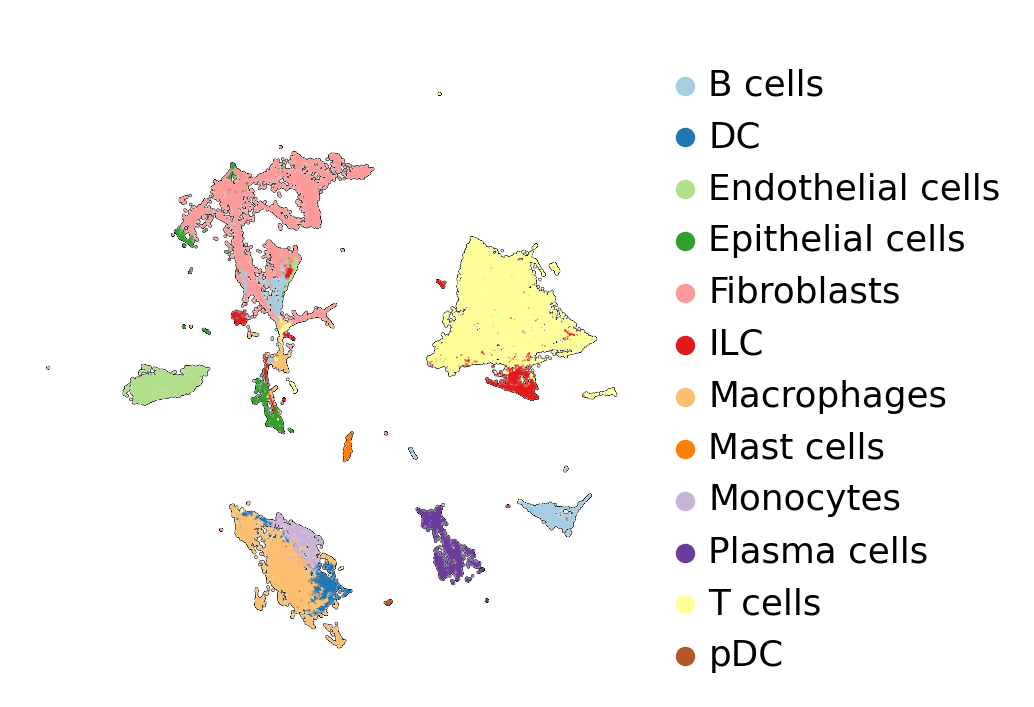

In [28]:
sc.pl.umap(adataCD45, color='majority_voting', add_outline=True,
           legend_fontoutline=1,frameon=False,
               title='  ', palette='Paired',s=2)

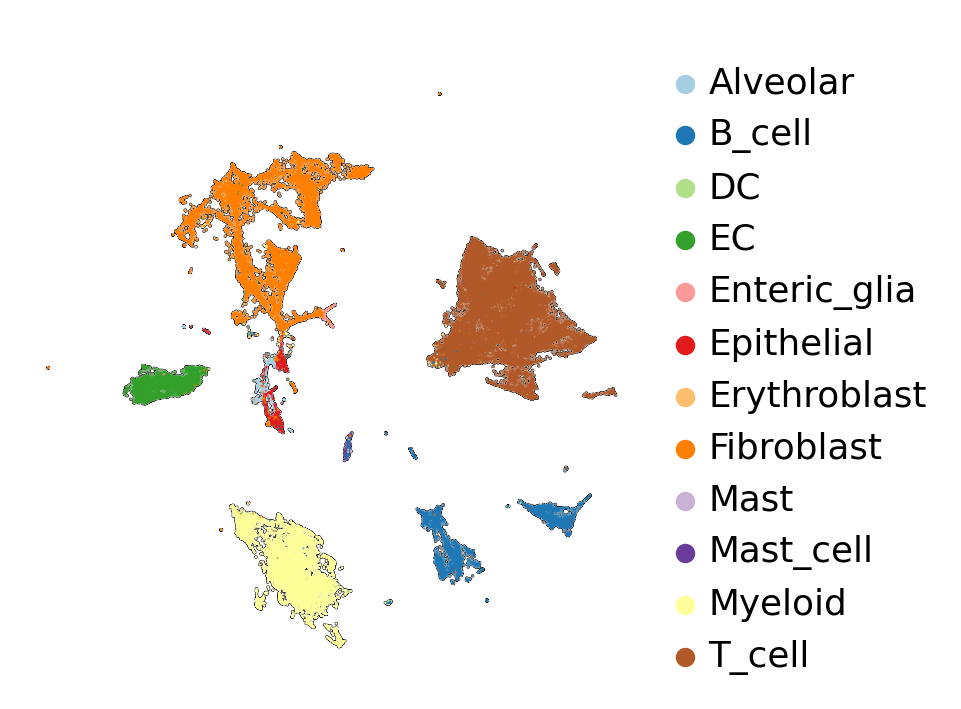

In [29]:
sc.pl.umap(adataCD45, color='CellType', add_outline=True,
           legend_fontoutline=1,frameon=False,
               title='  ', palette='Paired',s=2)

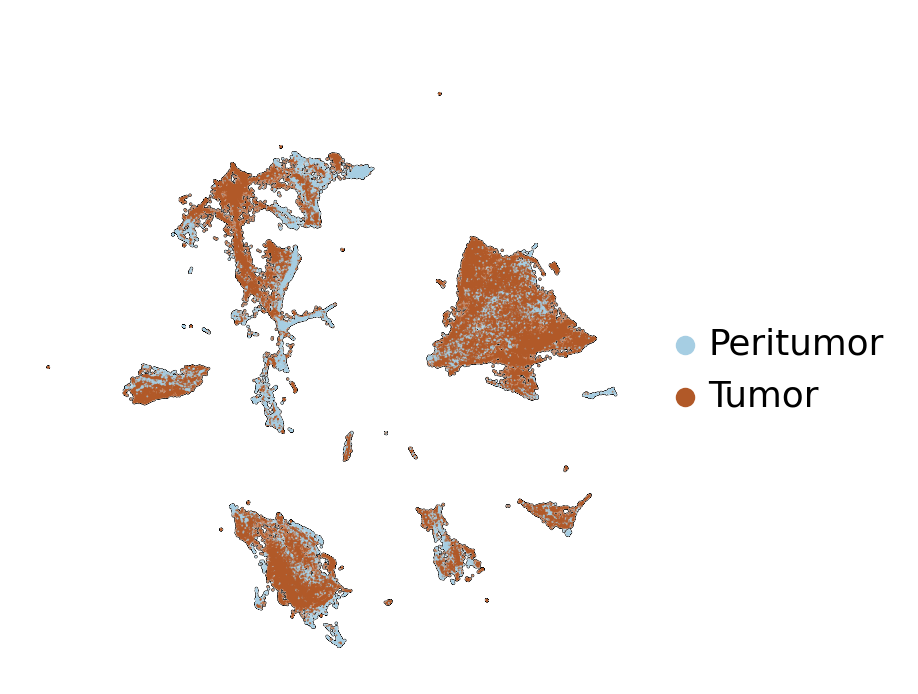

In [30]:
sc.pl.umap(adataCD45, color='CellFromTumor', add_outline=True,
           legend_fontoutline=1,frameon=False,
               title='  ', palette='Paired',s=2)

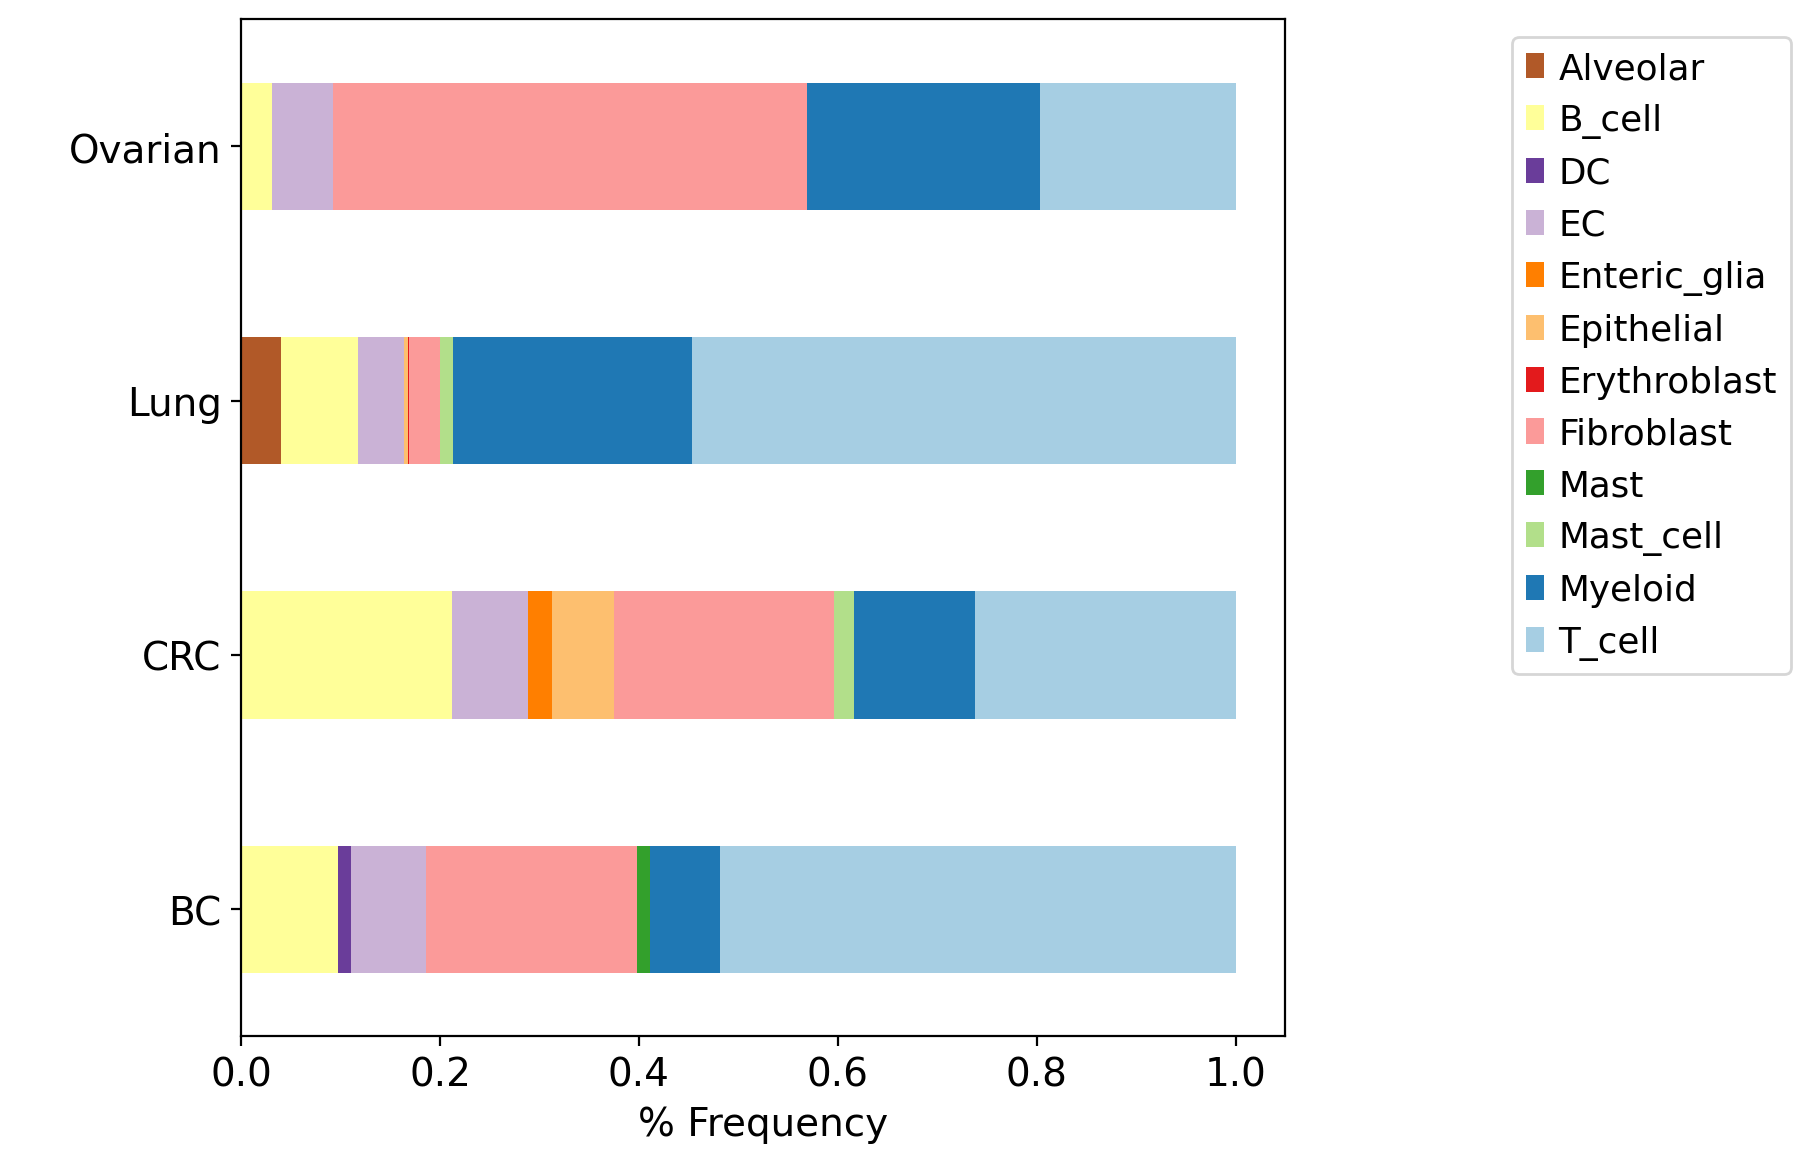

In [31]:
fig, (ax1) = plt.subplots(1,1, figsize=( 17/2.54,17/2.54))
ax1 = adataCD45.obs.groupby("TumorType")["CellType"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,colormap='Paired_r')
ax1.set_xlabel("% Frequency")
ax1.set_ylabel(" ")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

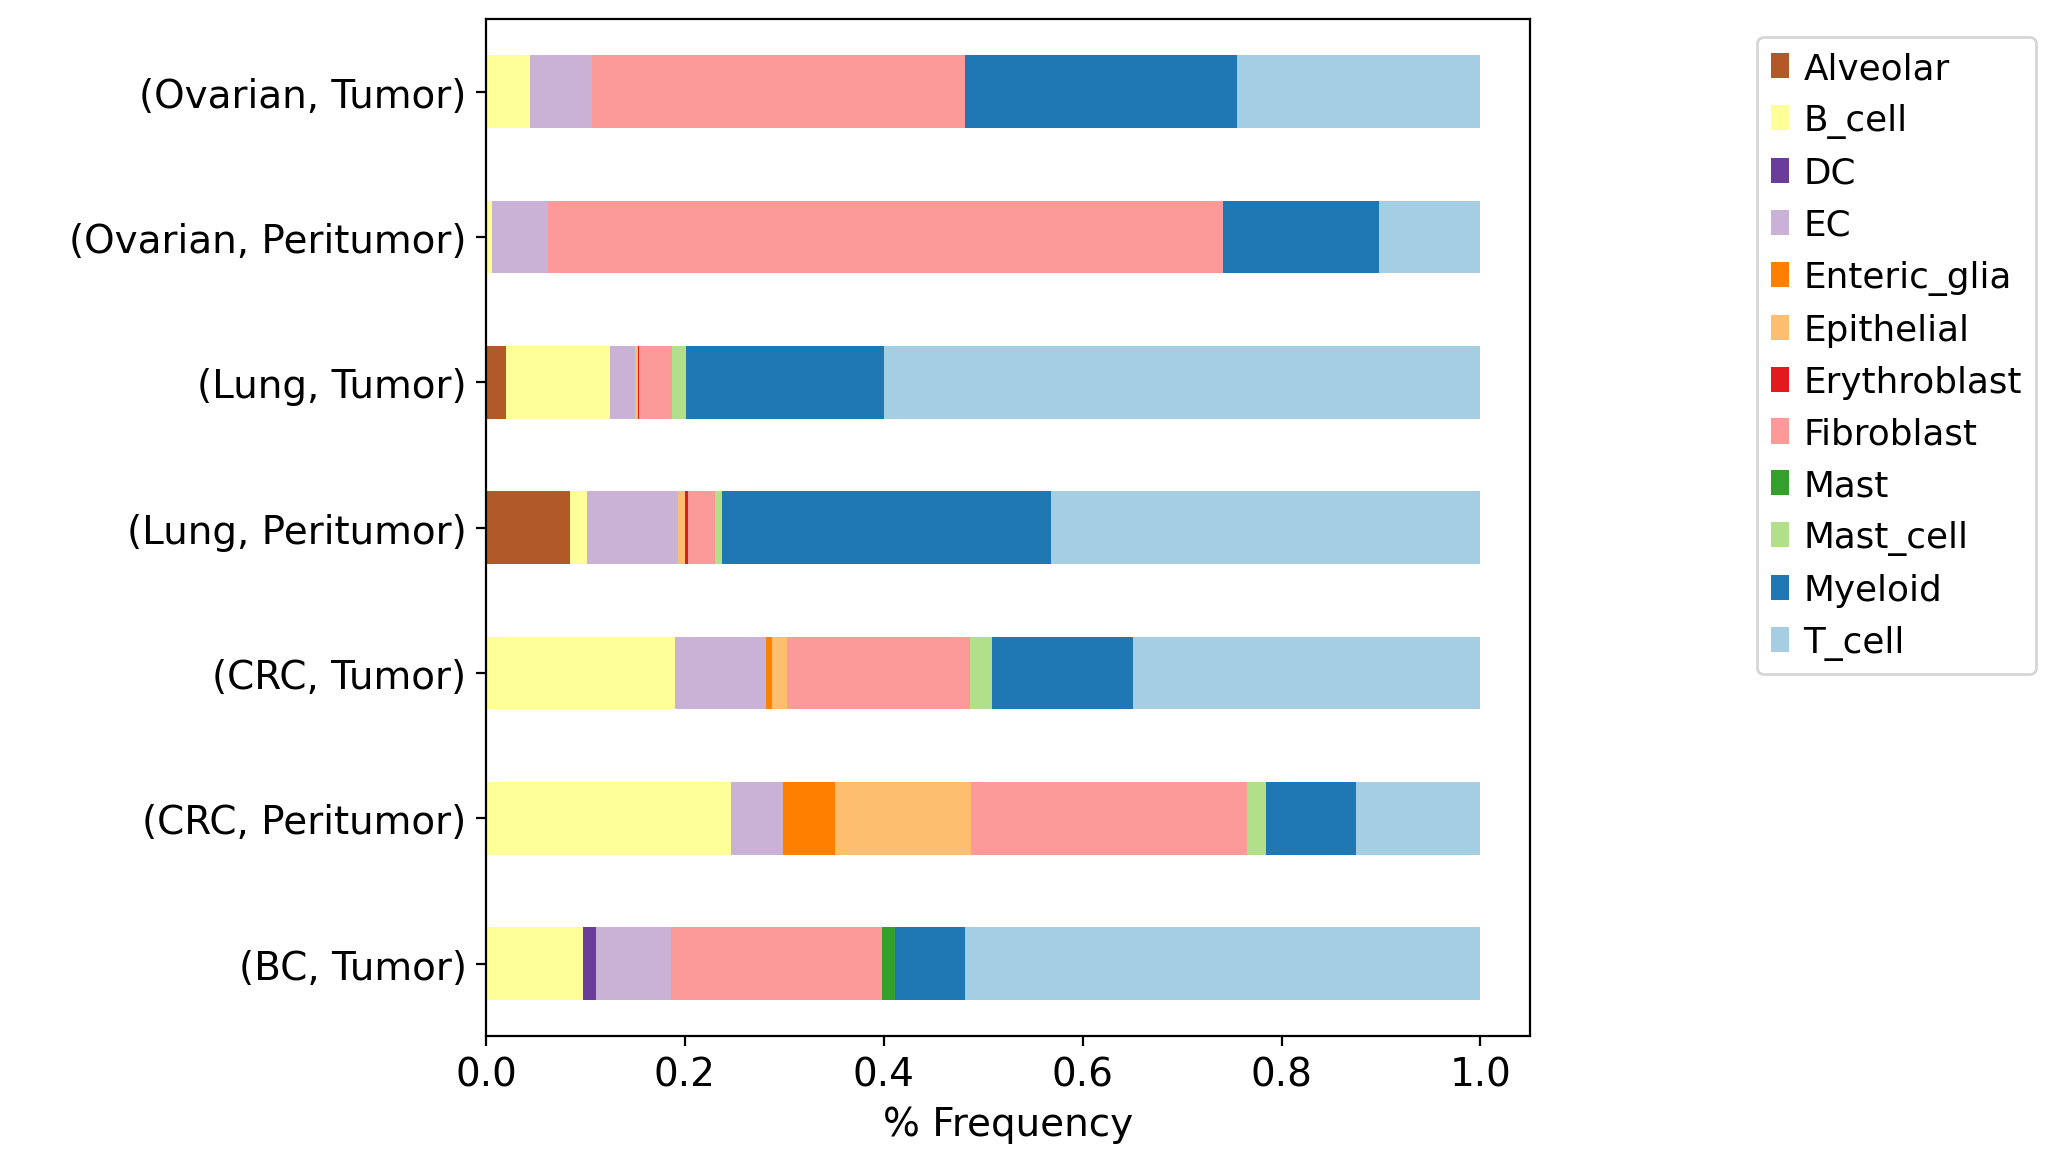

In [32]:
fig, (ax1) = plt.subplots(1,1, figsize=( 17/2.54,17/2.54))
ax1 = adataCD45.obs.groupby(["TumorType","CellFromTumor"])["CellType"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,colormap='Paired_r')
ax1.set_xlabel("% Frequency")
ax1.set_ylabel(" ")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

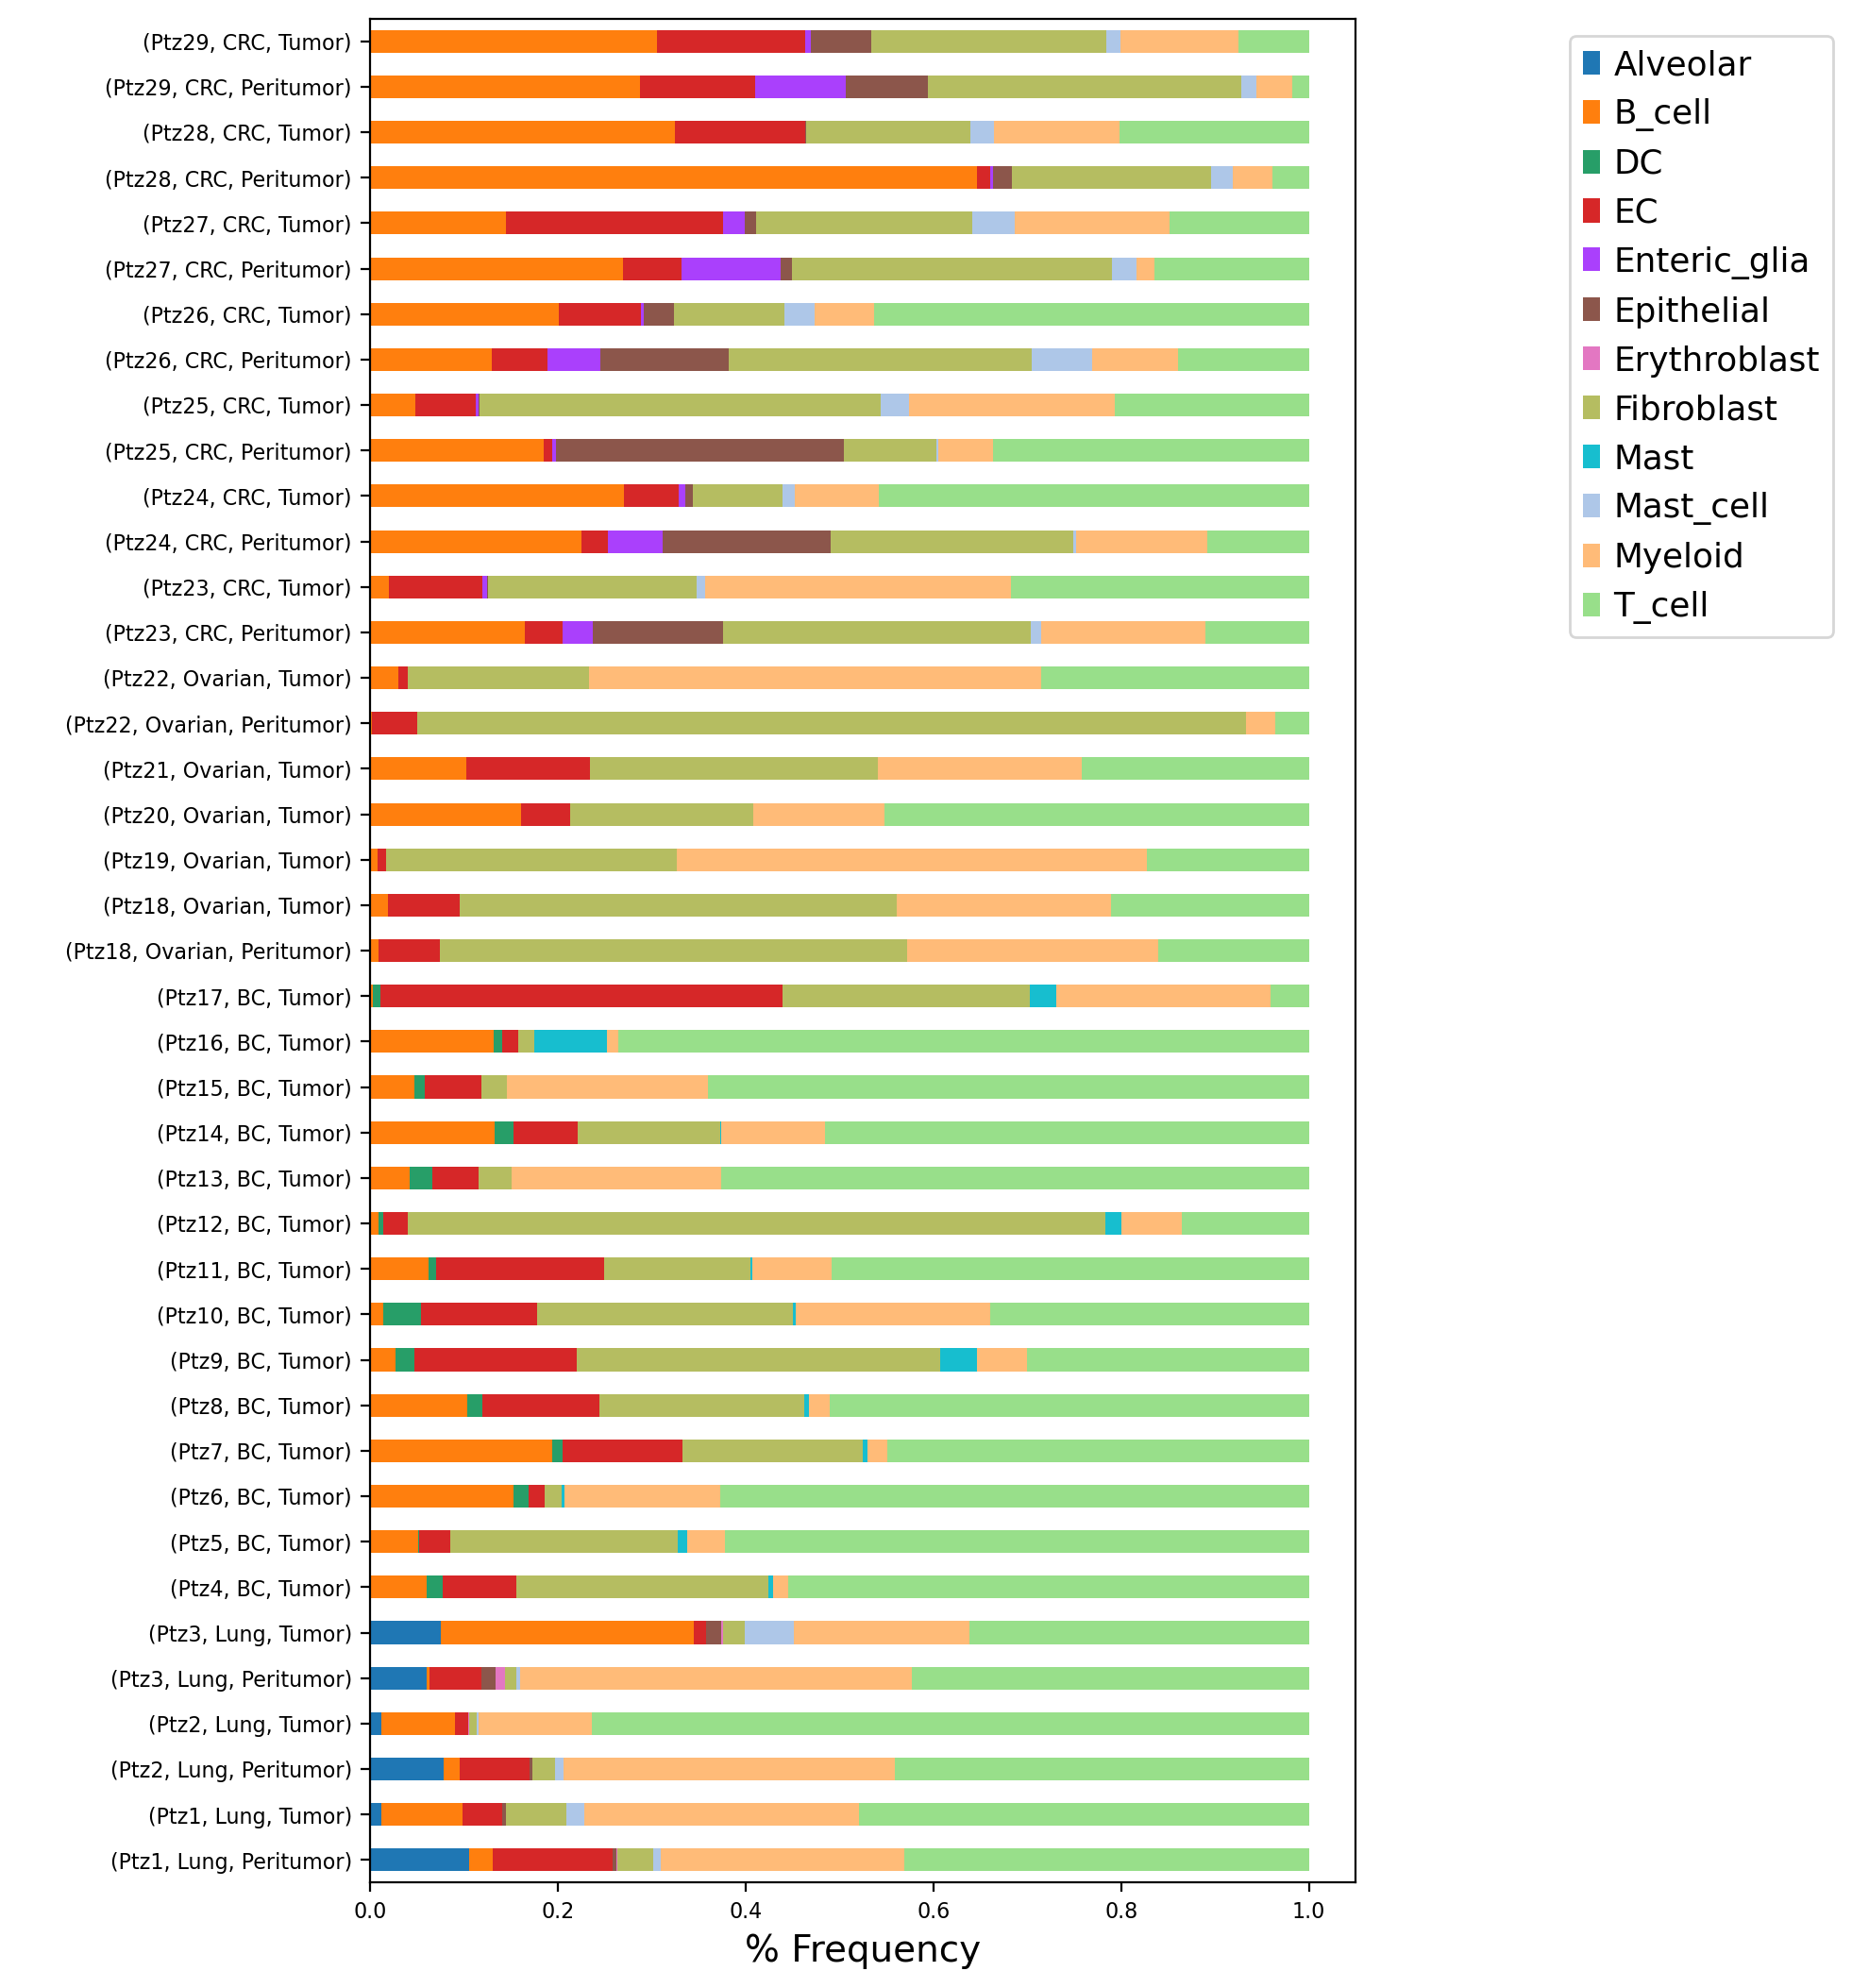

In [33]:
fig, (ax1) = plt.subplots(1,1, figsize=(17/2.54, 33/2.54 ))
ax1 = adataCD45.obs.groupby(["PatientNumber","TumorType","CellFromTumor"])["CellType"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,fontsize=8)
ax1.set_xlabel("% Frequency")
ax1.set_ylabel(" ")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

#### Keep T cell 

In [34]:
adataT = adataCD45[adataCD45.obs['CellType'].isin(['T_cell']),:]

#### Keep T cell from Tumor

In [35]:
adataT_fromTumor = adataT[adataT.obs['CellFromTumor'].isin(['Tumor']),:]

In [58]:
adataT = adataT[~adataT.obs['PatientNumber'].isin(['Ptz23']),:]

In [59]:
adataT_fromTumor = adataT_fromTumor[~adataT_fromTumor.obs['PatientNumber'].isin(['Ptz23']),:]

In [60]:
adataT.write("/home/lugli/spuccio/Projects/SP025_NaClTcell/Analysis/Tcell.h5ad")

In [61]:
adataT_fromTumor.write("/home/lugli/spuccio/Projects/SP025_NaClTcell/Analysis/TcellFromTumor.h5ad")